In [1]:
import os
import tensorflow as tf

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [3]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [4]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [5]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

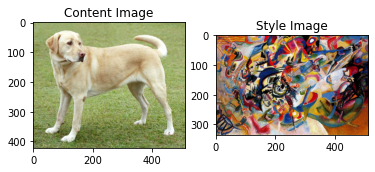

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [7]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [8]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

#print()
#for layer in vgg.layers:
#  print(layer.name)

In [9]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Build Model

In [10]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [11]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)


In [12]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [13]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [14]:
extractor = StyleContentModel(style_layers, content_layers)

# results = extractor(tf.constant(content_image))

Gradient Descent

In [15]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [16]:
# image = tf.Variable(content_image)

In [17]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [18]:
# opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [19]:
# style_weight=1e-2
# content_weight=1e4

In [20]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Re-Optimize

In [21]:
# total_variation_weight = 30

In [22]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [23]:
# image = tf.Variable(content_image)

In [24]:
#start = time.time()

#epochs = 1
#steps_per_epoch = 10

#step = 0
#for n in range(epochs):
#  for m in range(steps_per_epoch):
#    step += 1
#    train_step(image)
#    print(".", end='')
#  display.clear_output(wait=True)
#  display.display(tensor_to_image(image))
#  print("Train step: {}".format(step))

#end = time.time()
#print("Total time: {:.1f}".format(end-start))

OWN CODE

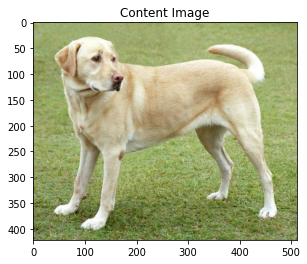

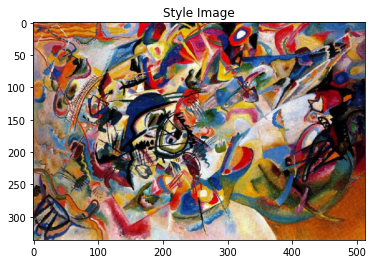

In [25]:
plt.figure(); imshow(content_image, 'Content Image')
plt.figure(); imshow(style_image, 'Style Image')

In [26]:
def style_content_loss(outputs, style_weight, content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [27]:
@tf.function()
def train_step(image, style_weight, content_weight, total_variation_weight, opt):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs, style_weight, content_weight)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [35]:
# controls 

def vgg19_neural_style_transfer(content_image, style_image, 
                                epochs = 1, steps_per_epoch = 10, 
                                seed = 5243, 
                                style_weight = 1e-2, content_weight = 1e4, 
                                total_variation_weight = 30,
                                opt = tf.optimizers.Adam(learning_rate = 0.02, beta_1 = 0.99, epsilon = 1e-1), 
                                display_content = True, 
                                display_style = True, 
                                display_render = True):
  tf.random.set_seed(seed)
  if display_content: 
    plt.figure(); imshow(content_image, 'Content Image')
  if display_style: 
    plt.figure(); imshow(style_image, 'Style Image')
  if display_render: 
    image = tf.Variable(content_image)
    start = time.time()
    step = 0
    for n in range(epochs):
      for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_weight, content_weight, total_variation_weight, opt)
        print(".", end='')
      display.clear_output(wait = True)
      display.display(tensor_to_image(image))
      print("Train step: {}".format(step))

      end = time.time()
      print("Total time: {:.1f}".format(end-start))


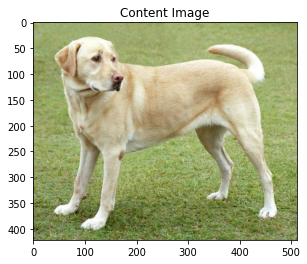

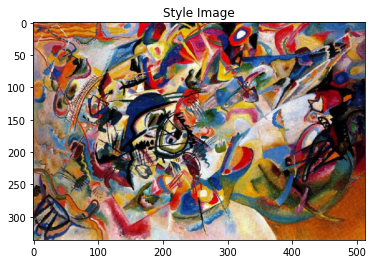

In [43]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)
extractor = StyleContentModel(style_layers, content_layers)
vgg19_neural_style_transfer(content_image = content_image, style_image = style_image, 
                            display_render = False)

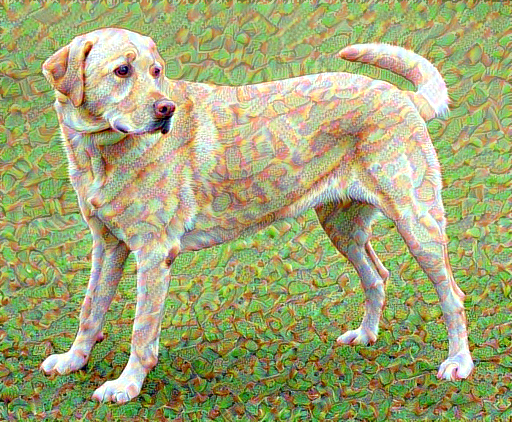

Train step: 10
Total time: 106.3


In [46]:
tf.config.run_functions_eagerly(True)

vgg19_neural_style_transfer(content_image = content_image, style_image = style_image, 
                            epochs = 1, steps_per_epoch = 10,
                            display_content = False, display_style = False)

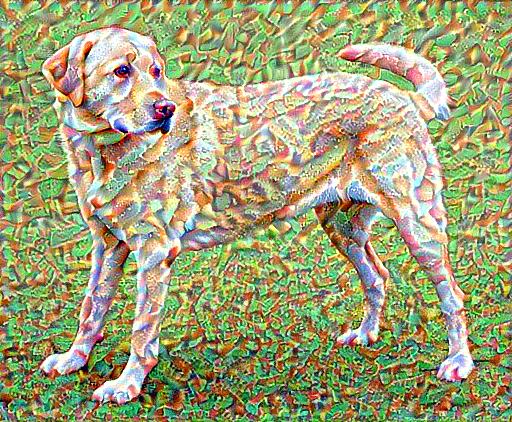

Train step: 40
Total time: 428.6


In [47]:
# tf.config.run_functions_eagerly(True)

vgg19_neural_style_transfer(content_image = content_image, style_image = style_image, 
                            epochs = 2, steps_per_epoch = 20,
                            display_content = False, display_style = False)

Inputs: content_image, style_image, epochs, steps_per_epoch, seed, style_weight, content_weight, total_variation_weight, opt

Controls: display_content, display_style, display_render




vgg19_neural_transfer (epochs, steps_per_epoch, seed)

*   imshow (content_image)
  *   load_image (content_path)
*   imshow (style_image)
  *   load_image (style_path)
*   train_step (total_variation_weight, opt)
  *   extractor (image)
      *   StyleContentModel (style_layers, content_layers)
      *   gram_matrix (tensor/image)
  *  style_content_loss (style_weight, content_weight)
  * clip_0_1 (tensor/image)
* tensor_to_image (tensor/image)



